# XBoost

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('../../data/raw/realistic_linear_regression_dataset.csv')
df.head()

,ProductCategory,Region,CustomerSegment,IsPromotionApplied,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,SalesRevenue
0,Furniture,East,High Income,Yes,536.051521,189.277811,1.159611,220.831351,4.035607,146.225757,52,2293.143707
1,Toys,West,High Income,No,352.701361,255.921497,1.545366,467.217175,4.106804,104.261304,35,1640.454368
2,Electronics,South,High Income,No,618.989105,277.399353,1.671902,363.623261,4.021775,77.220752,44,2173.086023
3,Furniture,West,Middle Income,Yes,339.959644,153.557699,1.408244,209.853621,4.148890,128.277455,15,1672.608857
4,Furniture,West,Middle Income,Yes,477.951385,155.814478,2.177301,274.859950,4.913782,111.309643,61,2443.222482


# Data Split

In [3]:
X = df.drop(columns=["SalesRevenue"])
y = df["SalesRevenue"]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(f"(X) Trainning Shape: {X_train.shape}")
print(f"(X) Test Shape: {X_test.shape}")

(X) Trainning Shape: (1600, 11)
(X) Test Shape: (400, 11)


## Preprocessing (Same as EDA notebook)

In [4]:
X_train["IsPromotionApplied"] = X_train["IsPromotionApplied"].map({'Yes': 1, 'No': 0})
X_test["IsPromotionApplied"] = X_test["IsPromotionApplied"].map({'Yes': 1, 'No': 0})

categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Not Bool type (True/False) -> Int (1/0)
dummy_cols_train = X_train.select_dtypes(include=["bool"]).columns
dummy_cols_test = X_test.select_dtypes(include=["bool"]).columns

X_train[dummy_cols_train] = X_train[dummy_cols_train].astype(int)
X_test[dummy_cols_test] = X_test[dummy_cols_test].astype(int)

# Align columns test with train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train.head()

,IsPromotionApplied,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Toys,Region_North,Region_South,Region_West,CustomerSegment_Low Income,CustomerSegment_Middle Income
968,1,706.324700,193.672022,0.691915,337.415950,3.469131,83.795709,10,0,0,0,0,0,0,0,0
240,0,419.829496,188.151586,1.374859,345.922550,4.805004,130.724965,82,0,0,0,1,0,0,1,0
819,0,516.855830,233.996923,1.499186,390.185659,3.865647,97.488531,86,1,0,0,0,1,0,0,0
692,1,244.368213,241.848794,1.081512,161.187309,3.968205,80.903238,83,1,0,0,0,0,1,1,0
420,0,518.793165,281.602125,1.224310,376.199077,3.637271,138.878918,12,0,0,0,1,0,0,0,0


In [5]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()

X_train[numeric_cols] = scaler_x.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_x.transform(X_test[numeric_cols])

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train.head()

,IsPromotionApplied,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Toys,Region_North,Region_South,Region_West,CustomerSegment_Low Income,CustomerSegment_Middle Income
968,1,2.083952,-0.150868,-1.549476,0.483381,-1.059334,-0.853222,-1.353726,0,0,0,0,0,0,0,0
240,0,-0.819344,-0.260931,-0.202668,0.587488,1.611386,1.587416,1.156725,0,0,0,1,0,0,1,0
819,0,0.163905,0.653104,0.042513,1.129195,-0.266607,-0.141103,1.296195,1,0,0,0,1,0,0,0
692,1,-2.597441,0.809650,-0.781167,-1.673368,-0.061570,-1.003650,1.191593,1,0,0,0,0,1,1,0
420,0,0.183538,1.602227,-0.499560,0.958022,-0.723184,2.011477,-1.283991,0,0,0,1,0,0,0,0


## XGBoost Model

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best score: -0.0942796215808166

=== XGBoost TRAIN ===
MAE Train: 60.8830
MSE Train: 5865.5452
MAPE Train: 0.0303
R² Train: 0.9509

=== XGBoost TEST ===
MAE Test: 80.1129
MSE Test: 10388.6808
MAPE Test: 0.0399
R² Test: 0.9135


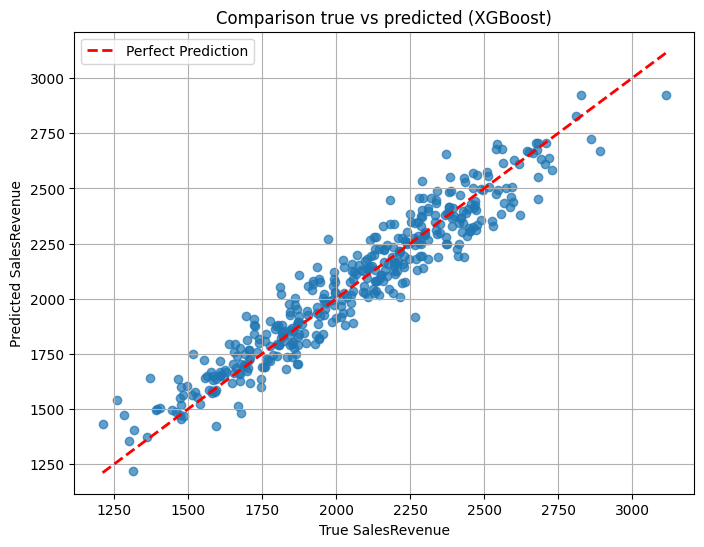

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# XGBoost Model
xgb_base = XGBRegressor(
    random_state=42
)

# Parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_scaled)
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

xgb = grid_search.best_estimator_
xgb.fit(X_train, y_train_scaled)

y_train_pred_scaled = xgb.predict(X_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_train_true = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))

y_test_pred_scaled = xgb.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))


mae_train_lr = mean_absolute_error(y_train_true, y_train_pred)
mse_train_lr = mean_squared_error(y_train_true, y_train_pred)
mape_train_lr = mean_absolute_percentage_error(y_train_true, y_train_pred)
r2_train_lr = r2_score(y_train_true, y_train_pred)

mae_test_lr = mean_absolute_error(y_test_true, y_test_pred)
mse_test_lr = mean_squared_error(y_test_true, y_test_pred)
mape_test_lr = mean_absolute_percentage_error(y_test_true, y_test_pred)
r2_test_lr = r2_score(y_test_true, y_test_pred)

print("\n=== XGBoost TRAIN ===")
print(f"MAE Train: {mae_train_lr:.4f}")
print(f"MSE Train: {mse_train_lr:.4f}")
print(f"MAPE Train: {mape_train_lr:.4f}")
print(f"R² Train: {r2_train_lr:.4f}")

print("\n=== XGBoost TEST ===")
print(f"MAE Test: {mae_test_lr:.4f}")
print(f"MSE Test: {mse_test_lr:.4f}")
print(f"MAPE Test: {mape_test_lr:.4f}")
print(f"R² Test: {r2_test_lr:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test_true, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel("True SalesRevenue")
plt.ylabel("Predicted SalesRevenue")
plt.title("Comparison true vs predicted (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()